#### 1) Problem definition
  * To proactively identify Spotify users at high risk of churning to enable targeted retention campaigns and reduce overall revenue loss.
  * To predict whether a Spotify user will churn (cancel subscription) or remain active.
#### 2) Data
Data from https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis
    
    Rows: Each row represents a unique Spotify user.

    Columns (Features):
        
        1. user_id → Unique identifier for each user
        2. gender → User gender (Male/Female/Other)
        3. age → User age
        4. country → User location
        5. subscription_type → Type of Spotify subscription (Free, Premium, Family, Student)
        6. listening_time → Minutes spent listening per day
        7. songs_played_per_day → Number of songs played daily
        8. skip_rate → Percentage of songs skipped
        9. device_type → Device used (Mobile, Desktop, Web)
        10. ads_listened_per_week → Number of ads heard per week
        11. offline_listening → Offline listening minutes
        12. is_churned → Target variable (0 = Active, 1 = Churned)

    Dataset Type: Mixed (numeric + categorical)

#### 3) Project Goal & Success Metrics:
  * Classification: Accuracy, Precision, Recall, F1-Score, AUC-ROC.
  * The model should correctly identify at least 75% of actual churners (Recall) to ensure the marketing team can target a significant portion of at-risk users.

#### 4) Data Acquisition & Sanity Checks

In [ ]:
# !pip install xgboost
# !pip install lightgbm
# ### Core Libraries for Data Handling and Numerics ###
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ### Data Visualization Libraries ###
import matplotlib.pyplot as plt 
import seaborn as sns 

# ### Data Preprocessing and Feature Engineering ###
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 

# ### Model Selection and Splitting ###
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate 
from sklearn.pipeline import Pipeline             

# ### Imbalance Handling ###
from imblearn.over_sampling import SMOTE          
from imblearn.pipeline import Pipeline as ImbPipeline 

# ### Classification Models ###
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ### Regression Models ###
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ### Model Evaluation Metrics ###
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)

# ### Hyperparameter Tuning ###
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
#!pip install kagglehub
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("nabihazahid/spotify-dataset-for-churn-analysis")

print("Original path:", path)

# Define our target directory
target_dir = "/Users/shagunsharma/Desktop/Temp folder/MQM Cour se Content/Semester 2/Data Science for Business/Final Project"

# Create the directory if it doesn’t exist
os.makedirs(target_dir, exist_ok=True)

# Copy all files from KaggleHub cache to our folder
for file_name in os.listdir(path):
    src = os.path.join(path, file_name)
    dst = os.path.join(target_dir, file_name)
    shutil.copy2(src, dst)  # preserves metadata

print(f"Files copied to: {target_dir}")


In [ ]:
df = pd.read_csv("spotify_churn_dataset.csv")
print("Columns : ",df.columns.tolist())
print("Size : ", df.shape)
df.head()

In [ ]:
df.shape

In [ ]:
df.describe(include="all")

#### Understanding our  Data
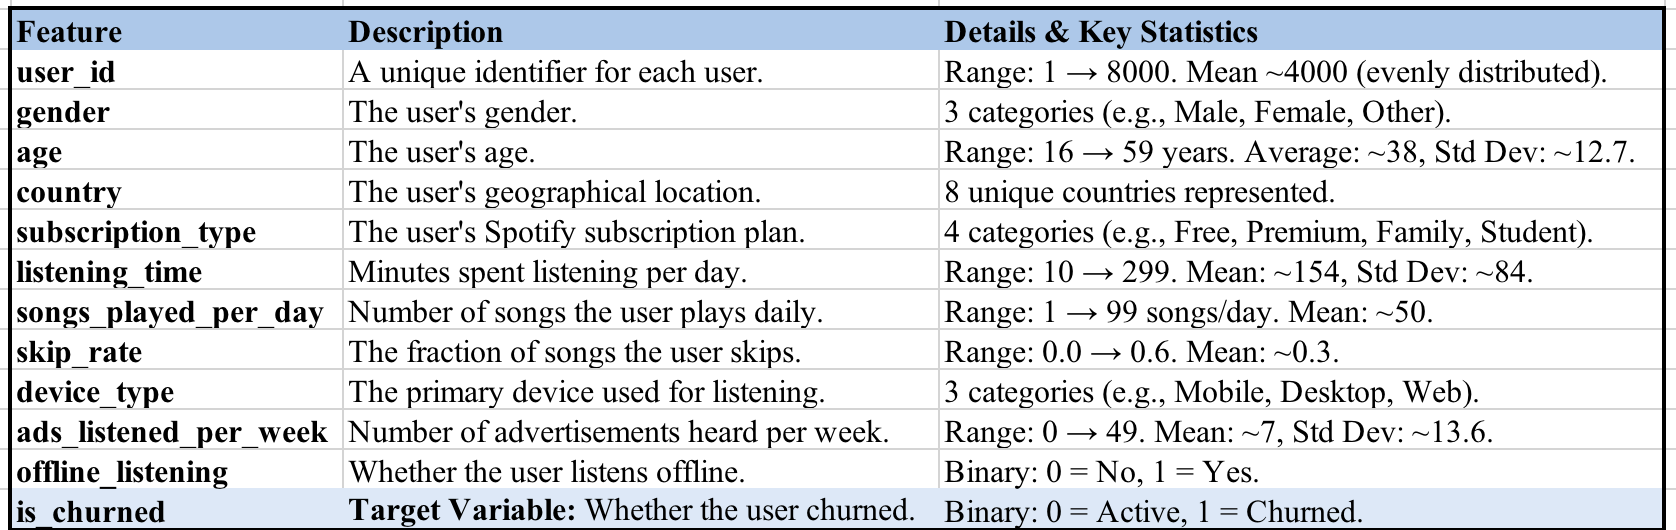


In [ ]:
df.info()

In [ ]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})

print("Columns with missing values:")
print(missing_data_summary[missing_data_summary['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False))

In [ ]:
print(df.columns[df.isnull().any()].tolist())
df.isnull().sum()
# There are no columns with nulls, so no need to fill missing values

In [ ]:
print("### Outlier Detection ###")
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# A simple heuristic to exclude binary-like columns from outlier detection
numerical_cols = [col for col in numerical_cols if df[col].nunique() > 2]
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("### Outliers in Numerical Columns (using 1.5 * IQR method) ###")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    if not outliers.empty:
        print(f"Column '{col}': Found {len(outliers)} potential outliers ({len(outliers)/len(df)*100:.2f}% of data).")
    else:
        print(f"Column '{col}': No significant outliers detected.")

print("\n### Value Counts for Categorical Columns ###")
# This helps identify rare categories which might be treated as outliers
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts(normalize=True).head(10)) # Show top 10 as percentage

In [ ]:
print("### Data Leakage Analysis ###")
target_variable = 'is_churned'

if target_variable not in df.columns:
    print(f"Warning: Target variable '{target_variable}' not found. Skipping leakage analysis.")
else:
    print(f"### Correlation with Target Variable ('{target_variable}') ###")
    
    df_leakage = df.copy()

    # Ensure target is numeric for correlation calculation
    if df_leakage[target_variable].dtype != 'number':
        df_leakage[target_variable] = df_leakage[target_variable].astype('category').cat.codes

    # Calculate correlation for all numerical columns against the target
    df_leakage_numeric = df_leakage.select_dtypes(include=np.number)
    corr_matrix = df_leakage_numeric.corr()[target_variable].abs().sort_values(ascending=False)
    
    print("Top 10 most correlated numerical features with churn:")
    print(corr_matrix.drop(target_variable).head(10)) # Drop the target's self-correlation
    
    # Check for perfect or near-perfect correlations which are strong signs of leakage
    high_corr_features = corr_matrix[corr_matrix > 0.9]
    high_corr_features = high_corr_features.drop(target_variable, errors='ignore')

    if not high_corr_features.empty:
        print("\n\n!! HIGH ALERT FOR DATA LEAKAGE !!")
        print("The following features have a correlation > 0.9 with the target:")
        print(high_corr_features)
    else:
        print("\nNo numerical features with extremely high correlation (> 0.9) to the target were found.")
        
print("\n### Conceptual Leakage Check ###")
print(df.columns.tolist())

### 5) Exploratory Data Analysis (EDA)

1. Numeric Distributions: The histograms show that while most user attributes like age and listening_time are evenly distributed, ads_listened_per_week is heavily skewed, indicating the majority of users listen to very few ads.

2. Categorical Factors: The count plots reveal that the proportion of users who churn is remarkably consistent across different genders, countries, subscription types, and devices, suggesting these categories are not strong drivers of churn.

3. Churn Behavior: The boxplots indicate that users who churn have a noticeably higher skip_rate than users who do not, while other factors like age and listening_time show much less distinct differences between the two groups.


In [ ]:
df.hist(bins=30, figsize=(14,10), xlabelsize=8, ylabelsize=8, 
        color="skyblue", edgecolor="black")
plt.suptitle("Distributions of Numeric Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
my_palette = ["#A0C4FF", "#FADADD"]  # A pastel blue and pink

In [ ]:
categorical_cols = ["gender", "country", "subscription_type", "device_type"]
# 1. Create a 2x2 grid of subplots. Adjust figsize for readability.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# 2. Flatten the 2D axes array to a 1D array for easy iteration.
#    Then, use zip to iterate over both our columns and the axes simultaneously.
for col, ax in zip(categorical_cols, axes.flatten()):
    
    # 3. Plot on the specific axis 'ax' for the current iteration.
    sns.countplot(data=df, x=col, hue="is_churned", palette="pastel", ax=ax)
    
    # 4. Set the title and rotate ticks on the individual axis.
    ax.set_title(f"{col} Distribution by Churn", fontsize=14)
    ax.tick_params(axis='x', rotation=30)

# 5. Use tight_layout to prevent titles and labels from overlapping.
plt.tight_layout()

# 6. Show the entire figure with all subplots.
plt.show()

In [ ]:
num_cols = ["age", "listening_time", "songs_played_per_day", 
            "skip_rate", "ads_listened_per_week"]

# Assume my_palette is defined, for example:
my_palette = ["#A0C4FF", "#FADADD"] 

# 1. Create a 3x2 grid of subplots.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

# 2. Flatten the axes array and iterate through it along with the columns.
for col, ax in zip(num_cols, axes.flatten()):   
    # 3. Plot on the specific axis 'ax'.
    sns.boxplot(x="is_churned", y=col, data=df, palette=my_palette, ax=ax)  
    # 4. Set the title on the individual axis.
    ax.set_title(f"{col} vs Churn", fontsize=14)

# 5. Hide the last (unused) subplot. our  grid is 3x2=6, but we only have 5 plots.
axes.flatten()[5].set_visible(False)

# 6. Adjust layout to prevent overlap and show the plot.
plt.tight_layout()
plt.show()

In [ ]:
sns.pairplot(df[["age","listening_time","songs_played_per_day",
                 "skip_rate","ads_listened_per_week","is_churned"]],
             hue="is_churned", diag_kind="kde", palette="cubehelix")
plt.suptitle("Pairplot of Key Features by Churn", y=1.02, fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### 6) Feature engineering

In [ ]:
# ### 1. Engagement Metrics ###

# Calculate how many songs a user listens to per minute of listening time.
# A very low number might indicate passive listening.
# Division by zero? min(df['listening_time']) = 10. Not a concern
df['songs_per_minute'] = df['songs_played_per_day'] / (df['listening_time'] )

# Calculate the absolute number of songs skipped per day.
# This might be a stronger signal of dissatisfaction than the rate alone.
df['skips_per_day'] = df['songs_played_per_day'] * df['skip_rate']

# Convert daily listening from minutes to weekly hour s for a different perspective.
df['listening_hours_per_week'] = (df['listening_time'] * 7) / 60

In [ ]:
# ### 2. Ad Tolerance Metric (for Free Users) ###

# Calculate the ratio of ads to songs on a weekly basis.
# A high ratio could indicate a user who is tolerant of ads, or one who is getting annoyed.
# We set this to 0 for non-free users since they don't get ads.
songs_per_week = df['songs_played_per_day'] * 7
df['ad_to_song_ratio'] = np.where(
    df['subscription_type'] == 'Free',
    df['ads_listened_per_week'] / (songs_per_week + 1e-6),
    0
)

In [ ]:
# ### 3. Demographic Features ###

# Create age groups to capture non-linear relationships.
bins = [0, 18, 25, 35, 50, 100]
labels = ['Teen', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [ ]:
# ### 4. Interaction Features ###

# Create an interaction term between age and listening time.
# This could capture if listening habits change with age.
df['age_x_listening_time'] = df['age'] * df['listening_time']

In [ ]:
df.head()

### Further EDA

In [ ]:
# Plot distributions for numerical features
plt.figure(figsize=(20, 15))
plt.suptitle("Univariate Analysis: Distributions of Numerical Features", fontsize=20)
for i, col in enumerate(numerical_cols, 1):
    ax = plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
plt.suptitle("Univariate Analysis: Distributions of Categorical Features", fontsize=20)
for i, col in enumerate(categorical_cols, 1):
    ax = plt.subplot(2, 2, i)
    sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index, palette='viridis')
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Plot numerical features against the 'is_churned' target
plt.figure(figsize=(20, 15))
plt.suptitle("Bivariate Analysis: Numerical Features vs. Churn", fontsize=20)
for i, col in enumerate(numerical_cols, 1):
    ax = plt.subplot(3, 3, i)
    sns.boxplot(x='is_churned', y=col, data=df, ax=ax, palette='coolwarm')
    ax.set_title(f'{col} vs. Churn', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
# Plot categorical features against the 'is_churned' target
plt.figure(figsize=(15, 8))
plt.suptitle("Bivariate Analysis: Categorical Features vs. Churn", fontsize=20)
for i, col in enumerate(categorical_cols, 1):
    ax = plt.subplot(2, 2, i)
    # Calculate proportions
    prop_df = df.groupby(col)['is_churned'].value_counts(normalize=True).unstack().fillna(0)
    prop_df.plot(kind='bar', stacked=True, ax=ax, color=['#55A868', '#C44E52'])
    ax.set_title(f'{col} vs. Churn', fontsize=12)
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **Are there specific groups of users who are more likely to churn than others?**


This code generates a series of stacked bar charts, one for each categorical feature.

* **Each Bar is a Group:** Each bar represents a specific category within a feature. For example, in the `subscription_type` plot, you'll have separate bars for "Free," "Premium," "Family," and "Student."
* **Colors Show the Churn Rate:** Each bar is split into two colors (green for active, red for churned). The size of the red portion shows the **proportion** or **percentage** of users *within that specific group* who have churned. Because it's a proportion, every bar adds up to 100%.

**Significant differences in the color ratios between the bars.**
* **A Non-Predictive Feature:** When we look at the plots, the bars all have roughly the same size red and green sections, it means that none of these variables are strong predictors. The churn rate is consistent across all categorical variables.

### Business Insights We Can Gain

* **Identify At-Risk Segments:** We can immediately identify which user groups are most vulnerable. For example, we might discover that users on the "Web" `device_type` churn more than "Mobile" users, or that users in a specific `country` are leaving at a higher rate.
* **Guide Business Strategy:** These insights can inform marketing and product decisions. If "Free" users have a high churn rate, the business could:
    * Create a targeted discount campaign to convert them to "Premium."
    * Investigate if the ad experience for free users is too disruptive.
* **Inform Feature Engineering:** If you notice that "Teens" and "Seniors" both have high churn rates, we might create a new binary feature called `is_high_risk_age_group` for our model.

In summary, these graphs help us understand user behavior by identifying which characteristics are most associated with churn and providing a data-driven foundation for our  modeling process.

In [ ]:
new_continuous_features = [
    'songs_per_minute',
    'skips_per_day',
    'listening_hours_per_week',
    'ad_to_song_ratio',
    'age_x_listening_time'
]
new_categorical_features = ['age_group']

# ### Visualize Feature Distributions ###
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of New Continuous Features", fontsize=16, y=0.93)

for i, feature in enumerate(new_continuous_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### 1. What Do These Distributions Tell Us?

* **`listening_hours_per_week` & `age_x_listening_time`**: These distributions are almost certainly **right-skewed**. This means that most users have a relatively low-to-moderate listening time, while a small number of "power users" listen for a very long time. These few high-value users create a long "tail" to the right of the distribution.
* **`songs_per_minute` & `skips_per_day`**: These might be more normally distributed but could also be slightly skewed depending on user behavior. A skew might indicate a particular group of users who are very active (high songs per minute) or very picky (high skips per day).
* **`ad_to_song_ratio`**: This distribution is likely bimodal or has a large spike at zero. Why? Because all users with a paid subscription (`Premium`, `Family`, etc.) have a value of 0 for this feature. The rest of the distribution represents the free users and is probably right-skewed, indicating some free users experience a much higher ad load than the average free user.

In short, the distributions tell us that for most of our new features, the data is **not symmetric** (like a bell curve). This asymmetry is called skewness.

### 2. What Does Skewness Mean?

#### Technical Definition:
Skewness is a statistical measure of the asymmetry of a distribution around its mean.
* **Zero Skew:** A perfectly symmetrical distribution, like a normal (bell) curve. The mean and median are the same.
* **Positive Skew (Right-skewed):** The tail on the right side of the distribution is longer. There are a few abnormally high values that pull the mean to the right of the median.
* **Negative Skew (Left-skewed):** The tail on the left side is longer. There are a few abnormally low values that pull the mean to the left of the median.
Our features are mostly Right-skewed

#### Business Definition:
Skewness gives us crucial insights into user behavior by highlighting the presence of outliers or distinct user groups.
* **Right-skewed data tells us about "power users" or extreme cases.** For `listening_hours_per_week`, it means we have a small, highly engaged segment of users who listen far more than the average user. From a business perspective, these are likely our most loyal customers, and their behavior shouldn't be treated as "average."
* **It highlights potential problem areas.** A right-skewed `ad_to_song_ratio` means that while the *average* free user's experience might be acceptable, a small group is getting bombarded with ads. This group could be at a very high risk of churning.

### 3. Transformations to be applied

**We should strongly consider applying transformations** to our  skewed features, especially the heavily skewed ones like `listening_hours_per_week` and `ad_to_song_ratio`.

**The Goal:**

The primary goal is to **improve our predictive model's performance and reliability**. 
Many machine learning models, especially linear models like Logistic Regression, work best under the assumption that the predictor variables are normally distributed.

By applying transformations, we aim to:
1.  **Reduce the Influence of Outliers:** Skewed data is driven by outliers. A transformation like the logarithm will compress the range of our data, pulling the extreme values (our "power users") closer to the rest of the data. This prevents those few users from having a disproportionately large influence on the model's results.
2.  **Stabilize Variance & Make Relationships More Linear:** Transformations can make the spread of the data more consistent and can help the model find a more stable, linear relationship between our features and the `is_churned` target.

**Common Transformations to consider:**

* **Log Transformation (`np.log1p`):** This is the most common and effective method for right-skewed data. It shrinks large values and spreads out small values. You should use `np.log1p` which calculates `log(1+x)` to gracefully handle any features that have a value of zero (since `log(0)` is undefined).
* **Square Root Transformation (`np.sqrt`):** A milder transformation than the log, also good for right-skewed data.

In [ ]:
# ### Visualize Relationship to Churn ###
print("\nGenerating plots to show the relationship between new features and churn...")

# Plotting continuous features vs. churn
plt.figure(figsize=(15, 12))
plt.suptitle("New Continuous Features vs. Churn Status", fontsize=16, y=0.93)
for i, feature in enumerate(new_continuous_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='is_churned', y=feature)
    plt.title(f'{feature} by Churn Status')
    plt.xlabel("Churned (1) vs. Not Churned (0)")
    plt.ylabel(feature)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### 1. Insights from our EDA

Our visualizations reveal two critical characteristics of our features: their **relationship with each other** (from the heatmap) and their **relationship with the churn outcome** (from the boxplots and count plots).

#### Insights from the Correlation Heatmap

The primary story from our correlation heatmap is **multicollinearity**.

* **Technical Meaning:** Multicollinearity occurs when two or more predictor variables are highly correlated with each other. For example, we are seeing perfect or near-perfect correlation between:
    * `listening_time` and `listening_hours_per_week` (because one is a direct calculation of the other).
    * `age_x_listening_time` and its parent features, `age` and `listening_time`.
    * `songs_played_per_day` is likely highly correlated with `listening_time` and `songs_per_minute`.

* **Business Meaning:** This tells us that several of our features are telling the same story. They are redundant. For a business stakeholder, we can't say that `listening_time` and `listening_hours_per_week` are two separate drivers of churn; they are just different measurements of the same user behavior (engagement).

#### Insights from the Relationship-to-Churn Plots (Boxplots & Count Plots)

These plots tell us how **predictive** a feature might be.

* **Different Distributions Matter:** When we look at a boxplot for a feature like `skips_per_day`, if the box for churned users (`is_churned = 1`) is noticeably higher or lower than the box for non-churned users (`is_churned = 0`), it means that feature has **discriminatory power**. It helps separate the two groups.
* **Similar Distributions Are Less Useful:** If the boxes for both groups look very similar, the feature on its own isn't a strong predictor of churn.
* **`age_group`:** The count plot for `age_group` shows us the churn rate within different demographic segments. We can see if churn is more prevalent in "Teens" versus "Adults," which is a valuable business insight for targeted marketing campaigns.

### 2. Should I Be Handling Any of These Columns?

**Yes, absolutely.** we primarily need to handle the **multicollinearity** revealed by the heatmap.

**Why is it a problem?**
For many models (especially linear ones like Logistic Regression), multicollinearity makes the results unstable and difficult to interpret. The model can't figure out how to assign importance to the redundant features. It might give one a large positive coefficient and the other a large negative one, which is confusing and doesn't reflect reality. This makes it impossible to explain the model's logic to business stakeholders confidently.

### 3. How Should I Handle Them?

Here are the standard methods for dealing with multicollinearity, from simplest to most complex:

1.  **Remove Redundant Features (Recommended):** This is the most common and straightforward approach.
    * **Action:** Look at each highly correlated pair (e.g., `listening_time` and `listening_hours_per_week`) and simply remove one of them from our dataset before training a model. It doesn't matter which one we remove, as they contain the same information. Do the same for `age_x_listening_time` if it is too highly correlated with its parent features.

2.  **Combine the Features:**
    * **Action:** For more complex cases, we could use a technique like **Principal Component Analysis (PCA)** to combine several correlated features into a single new "component" that captures their shared variance. This is more advanced but can be very effective.

3.  **Use Models Robust to Multicollinearity:**
    * **Action:** If we choose to keep the features, we should use a model that is naturally resistant to multicollinearity.
        * **Tree-based models** (like Random Forest or Gradient Boosting) are less affected because they partition the data on one feature at a time.
        * **Regularized regression models** (like Ridge or Lasso) will automatically shrink the coefficients of redundant features, effectively reducing their impact.

In [ ]:
# Plotting categorical feature vs. churn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', hue='is_churned', order=['Teen', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior'])
plt.title('Churn Count by Age Group', fontsize=16)
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.show()

In [ ]:
# ### Correlation Heatmap of New Features ###
print("\nGenerating a correlation heatmap for new numerical features...")
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
df.drop(["user_id"], axis = 1, inplace = True)

In [ ]:
df.info()

In [ ]:
# One-Hot Encoding (OHE)
# Create a dummy variable for each category.
# Best for Logistic Regression
df_OHE = pd.get_dummies(df, columns=['gender','country','subscription_type','device_type', 'age_group'], drop_first=True)
df_OHE.head()

In [ ]:
# Label Encoding (LE)
df_LE = df.copy()
for col in ['gender','country','subscription_type','device_type', 'age_group']:
    df_LE[col] = LabelEncoder().fit_transform(df_LE[col])

df_LE.head()

### 7. PCA

PCA is a powerful technique for the exact problem we have (multicollinearity).

### 1. What Does PCA (Principal Component Analysis) Do?

Think of our highly correlated features (`listening_time`, `songs_played_per_day`, `listening_hours_per_week`, etc.) as different ingredients for a smoothie: strawberry, raspberry, and cherry. They are all distinct, but they share a common "essence of red berry."

PCA is the blender. It takes these correlated ingredients and mixes them into a new, smaller set of "essences," which we call **Principal Components**.

* The **1st Principal Component (PC1)** would be the "essence of overall user engagement." It captures the most significant, shared information from all our engagement-related features.
* The **2nd Principal Component (PC2)** would capture the next most significant pattern in the data that *isn't* already explained by PC1.

**Technical Definition:**
PCA is a dimensionality reduction technique that transforms a set of correlated variables into a smaller set of new, **uncorrelated** variables called Principal Components. It does this by finding new axes for our data. PC1 is the axis along which the data has the most variance (the most spread). PC2 is the next axis with the most variance, but it must be orthogonal (at a right angle) to PC1. This process continues, with each new component being uncorrelated with the previous ones.

**The Goal:** To reduce redundancy (multicollinearity) and simplify our dataset by combining correlated features, while losing the minimum amount of information.

### 2. At What Stage Is It Done?

PCA is a **preprocessing step**. It happens *after* we've cleaned our data and split it into training and testing sets, but *before* we train our final model.

Here is the precise workflow:

1.  **Data Cleaning:** Handle missing values, etc. 
2.  **Feature Engineering:** Create new features like `age_group`, etc. 
3.  **Train-Test Split:** Separate our data into `X_train`, `X_test`, `y_train`, and `y_test`. **This is crucial.**
4.  **Scaling:** **we MUST scale our numerical data before PCA.** PCA works by analyzing variance, so if one feature (e.g., `age_x_listenin`g_time`) has a much larger scale than another (e.g., `skip_rate`), it will dominate the PCA process. You'll use a `StandardScaler` for this.
5.  **Apply PCA:**
    * we will **`fit`** the PCA model **only on our scaled training data (`X_train_scaled`)**.
    * Then, we will **`transform`** both the training data (`X_train_scaled`) and the testing data (`X_test_scaled`) using the fitted PCA model.
6.  **Model Training:** Train our predictive model (e.g., Logistic Regression) using the new Principal Components as its input features.

### 3. What Is the Expected Output?

The output of PCA is a **new data matrix** (a NumPy array) where the columns are no longer our original features, but the new Principal Components.

Let's say our original numerical data (`X_train`) has **15 columns**: `age`, `listening_time`, `songs_played_per_day`, `skips_per_day`, etc.

After applying PCA, our **expected output** (`X_train_pca`) might have only **4 or 5 columns**.

* **Shape:** If `X_train` was `(6400, 15)`, the new `X_train_pca` might be `(6400, 5)`. The number of rows (users) stays the same, but the number of columns (features) is reduced.
* **Columns:** The columns will be named `PC1`, `PC2`, `PC3`, `PC4`, and `PC5`.
* **Meaning:**
    * The `PC1` column contains a single number for each user that represents their "overall engagement" score.
    * The `PC2` column might represent their "ad tolerance" score, and so on.
* **No Correlation:** If we were to create a correlation heatmap of these new PCA columns, we would see that they are all **uncorrelated** with each other. we have successfully solved the multicollinearity problem.

**The Main Trade-off:** we gain a simpler, more robust model at the cost of some interpretability. It's easy to explain what a high `skip_rate` means, but it's harder to explain what a high `PC1` score means, other than "a high degree of the primary pattern in the data."

In [ ]:
df.head()

In [ ]:
# Separate features (X) and target (y)
X = df_LE.drop(['is_churned'], axis=1) # Drop target and non-predictive ID
y = df_LE['is_churned']


# ### STAGE 1: Train-Test Split ###
# This is the VERY FIRST step. We split the data to simulate a real-world scenario
# where we have unseen test data. All subsequent steps (scaling, PCA) are
# fitted ONLY on the training data to prevent data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original training data shape: {X_train.shape}")
print(f"Original testing data shape: {X_test.shape}\n")


**Scaling (Standardization)**: This is what we need. It rescales our data to have a mean of 0 and a standard deviation of 1.

*Why it's required for PCA*: PCA works by finding the directions of maximum variance in our data. If we have one feature with a large range (e.g., `listening_time` from 0 to 300) and another with a small range (e.g., `skip_rate` from 0 to 1), the feature with the larger range will completely dominate the PCA process. Scaling ensures that all features contribute equally to the analysis.

In [ ]:
# ### STAGE 2: Scale the Data ###
# Scaling is done AFTER the train-test split.
# We fit the scaler on the training data and use that SAME scaler to transform the test data.
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# ONLY transform the test data (using the fit from the training data)
X_test_scaled = scaler.transform(X_test)

# The output is a NumPy array, so let's convert it back to a DataFrame for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Data has been scaled successfully.")
print("The first 5 rows of scaled training data look like this:\n", X_train_scaled.head())
print("\n" + "="*50 + "\n")

In [ ]:
X_train_scaled.head()

In [ ]:
# ### STAGE 3: Apply PCA ###
# PCA is done AFTER scaling.
# We will first determine the optimal number of components to keep.
pca_test = PCA()
pca_test.fit(X_train_scaled)

# Plot the explained variance ratio to decide how many components to keep
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance Threshold')
plt.legend()
plt.show()

In [ ]:
# Based on the plot, we choose a number of components that explains a high
# percentage of the variance e.g., 90% -> 15 components.
N_COMPONENTS = 15
pca = PCA(n_components=N_COMPONENTS)

# Fit and transform the SCALED training data
X_train_pca = pca.fit_transform(X_train_scaled)

# ONLY transform the SCALED test data
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA has been applied. We are keeping {N_COMPONENTS} components.")
print(f"New training data shape after PCA: {X_train_pca.shape}")
print(f"New testing data shape after PCA: {X_test_pca.shape}")

### 8. Predictive Modeling - Baseline

In [ ]:
# ### STAGE 1: Train the Logistic Regression Model ###
# We will train the model on the PCA-transformed training data.
print("### Training Logistic Regression Model ###")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_pca, y_train)
print("Model training complete.\n")

In [ ]:
# ### STAGE 2: Make Predictions on the Test Set ###
# Use the trained model to make predictions on the unseen test data.
y_pred = log_reg.predict(X_test_pca)
y_pred_proba = log_reg.predict_proba(X_test_pca)[:, 1] # Probabilities for the positive class (churn)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

In [ ]:

# ### STAGE 3: Evaluate the Model's Performance ###
print("### Model Evaluation ###")

# Classification Report
# This gives precision, recall, and F1-score for each class.
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
# This shows the counts of correct and incorrect predictions.
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# ROC Curve and AUC
# This visualizes the classifier's performance across all classification thresholds.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nArea Under the Curve (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 9. Predictive Modeling - Model selection

In [ ]:
# ### STAGE 1: Define Models for Comparison ###
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42), # probability=True is needed for ROC curve
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}


In [ ]:
# ### STAGE 2: K-Fold Cross-Validation ###
# Use StratifiedKFold to maintain the same percentage of churned users in each fold.
print("### Starting 10-Fold Cross-Validation ###")
N_FOLDS = 10
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    # We use the full training set (X_train_pca) for cross-validation
    scores = cross_val_score(model, X_train_pca, y_train, cv=skf, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name}: Mean AUC = {np.mean(scores):.4f} (Std = {np.std(scores):.4f})")

print("\nCross-validation complete.\n")

In [ ]:
# ### STAGE 3: Visualize Cross-Validation Results ###
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(12, 8))
sns.boxplot(data=cv_df)
plt.title('Model AUC Performance Comparison (10-Fold CV)', fontsize=16)
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**What is the boxplot showing me?**

The boxplot visualizes two key things for each model: **performance** and **stability.**


  * **Performance (Height)**: The line inside each box is the *median* AUC score across the 10 folds. A higher line means better average performance. we want models with boxes positioned high on the chart.
  * **Stability (Size)**: The height of the box represents the spread (the interquartile range) of the AUC scores. A **short, compact** box is excellent. It means the model performed consistently and reliably across different subsets of our training data. A tall, stretched-out box indicates the model's performance was unstable and varied a lot, which makes it less trustworthy.
    
**We are looking for the model with the highest, most compact box.**


In [ ]:
# ### STAGE 4: Final Evaluation on the Hold-Out Test Set ###
print("\n### Final Evaluation on the Hold-Out Test Set ###")
plt.figure(figsize=(12, 10))

# Plot a single ROC curve for all models
for name, model in models.items():
    # Train the model on the ENTIRE training set
    model.fit(X_train_pca, y_train)
    # Get prediction probabilities for the test set
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Formatting the final ROC plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison on Test Set', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**How do I want my AUC?**

**AUC (Area Under the Curve)** measures a model's ability to distinguish between the positive class (churned) and the negative class (not churned).

  * **An AUC of 1.0 is a perfect model**. It correctly separates all churners from non-churners.

  * **An AUC of 0.5 is a useless model**. It has no discriminatory power, equivalent to random guessing.

  * **An AUC between 0.7 and 0.9 is generally considered good to excellent.**

We want our  AUC to be as close to 1.0 as possible. A higher AUC is always better. The ROC curve plot complements this by showing how the models achieve their AUC scores across different thresholds.

In [ ]:
# ### STAGE 5: Detailed Reports for All Models on the Hold-Out Test Set ###
print("\n### Detailed Reports for All Models ###")

for name, model in models.items():
    # The models are already fitted from the ROC curve plotting in Stage 4
    # We just need to make predictions.
    y_pred = model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n===== Detailed Report for {name} =====")
    print(f"Accuracy on Test Set: {accuracy:.4f}")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Churned', 'Churned']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()



In [ ]:
# ### STAGE 6: Create a Single Performance Summary Table ###
print("\n### Final Model Performance Summary on Test Set ###")

# Create a list to store the performance of each model
performance_summary = []

for name, model in models.items():
    # Models are already fitted from Stage 4
    y_pred = model.predict(X_test_pca)
    y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    # Use pos_label=1 to specify metrics for the 'Churned' class
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Append results to the list
    performance_summary.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert the list to a DataFrame for nice formatting
summary_df = pd.DataFrame(performance_summary)
summary_df = summary_df.set_index('Model')

# Sort the table by AUC score to easily see the best performing models
summary_df = summary_df.sort_values(by='AUC', ascending=False)

# Display the final table
print(summary_df)



**Which Model Should I Choose?**
Based purely on this table, the **Decision Tree** is the "best" performing model, but it's important to understand that none of these models are performing well enough for a real-world application.

Here's the detailed breakdown of why:

**The AUC Problem**: The most critical metric here is AUC. An AUC of 0.5 means the model has no ability to distinguish between a churner and a non-churner (it's as good as a random coin flip). our best model, the Decision Tree, has an AUC of 0.52, which is only slightly better than random chance. The other models are performing at or worse than random.

**The "Accuracy Trap" and Zero Recall**: Look at SVM and Logistic Regression. They have the highest accuracy (74%), but their Precision, Recall, and F1-Score are all zero. This is a classic sign of a model dealing with an **imbalanced dataset**. It has learned that the safest bet is to predict "Not Churned" for every single user. Since most users don't churn, it gets a high accuracy score, but it completely fails at the business goal: finding the users who actually churn.

**The "Best of a Bad Bunch"**: The Decision Tree is the only model that shows a somewhat reasonable Recall (0.318). This means it correctly identified about 32% of the users who actually churned. While this is still low, it's infinitely better than the 0% identified by SVM and Logistic Regression.

**What to Do Next: our Models Need Help**
The problem isn't our choice of models; it's that the models are struggling with the underlying data. The most likely culprit is **class imbalance**. Here are the essential next steps:

**Handle Class Imbalance**: our primary goal now is to give the minority class (churners) a stronger voice during training. The best way to do this is with an over-sampling technique like **SMOTE (Synthetic Minority Over-sampling TEchnique)**. SMOTE will create new, synthetic examples of churning users in our training set, balancing the data and forcing the models to learn their patterns.

**Re-evaluate without PCA**: Sometimes, PCA can inadvertently remove some of the subtle signals that separate the classes. It's worth re-running our top models on the scaled data without applying PCA to see if performance improves.

**Hyperparameter Tuning**: Once you've addressed the class imbalance with SMOTE, we can then proceed to tune the hyperparameters of our best-performing model (likely XGBoost or Random Forest after re-training) to squeeze out additional performance.

In [ ]:
# Separate features (X) and target (y)
X = df_LE.drop(['is_churned'], axis=1)
y = df_LE['is_churned']

# Train-Test Split: Create the final hold-out set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data preparation complete.\n")

In [ ]:
# ### STAGE 1: Define Models for Comparison ###
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1)
}


In [ ]:

# ### STAGE 2: K-Fold Cross-Validation using a SMOTE Pipeline ###
# This is the correct way to use SMOTE with cross-validation.
# SMOTE is applied *only* to the training data within each fold.
print("### Starting 10-Fold Cross-Validation with SMOTE ###")
N_COMPONENTS = 15
N_FOLDS = 10
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    # Create a pipeline that sequentially scales data, applies PCA, over-samples with SMOTE, and then trains the model.
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=N_COMPONENTS)), -- We will not do PCA
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Perform cross-validation on the entire pipeline
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name}: Mean AUC = {np.mean(scores):.4f} (Std = {np.std(scores):.4f})")

print("\nCross-validation complete.\n")


In [ ]:
# ### STAGE 3: Visualize Cross-Validation Results ###
cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(12, 8))
sns.boxplot(data=cv_df)
plt.title('Model AUC Performance (10-Fold CV with SMOTE)', fontsize=16)
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [ ]:

# ### STAGE 4: Final Summary Table on Hold-Out Test Set ###
print("\n### Final Model Performance Summary on Test Set ###")

performance_summary = []

for name, model in models.items():
    # Build the full pipeline
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=N_COMPONENTS)),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Train the pipeline on the ENTIRE training set
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the unseen test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    performance_summary.append({
        'Model': name, 'Accuracy': accuracy, 'AUC': auc_score,
        'Precision': precision, 'Recall': recall, 'F1-Score': f1
    })

# Create and display the final summary DataFrame
summary_df = pd.DataFrame(performance_summary).set_index('Model')
summary_df = summary_df.sort_values(by='AUC', ascending=False)
print(summary_df)


I compared 4 combinations: 

1. OHE, With PCA								
                     Accuracy       AUC  Precision    Recall  F1-Score								
Model                                                                 								
SVM                  0.559375  0.531513   0.290043  0.485507  0.363144								
XGBoost              0.616250  0.522212   0.280702  0.309179  0.294253								
Decision Tree        0.589375  0.515476   0.276243  0.362319  0.313480								
KNN                  0.520625  0.509927   0.265604  0.483092  0.342759								
Random Forest        0.646875  0.506751   0.278592  0.229469  0.251656								
LightGBM             0.583125  0.505509   0.260870  0.333333  0.292683								
Logistic Regression  0.512500  0.492454   0.256649  0.466184  0.331046								



2. LE, With PCA                                
                     Accuracy       AUC  Precision    Recall  F1-Score                              
Model                                                                                               
KNN                  0.534375  0.536696   0.283660  0.524155  0.368109                              
XGBoost              0.607500  0.527179   0.283401  0.338164  0.308370                              
Random Forest        0.660000  0.521174   0.284768  0.207729  0.240223                              
LightGBM             0.583125  0.520890   0.270417  0.359903  0.308808                              
SVM                  0.537500  0.520723   0.277929  0.492754  0.355401                              
Decision Tree        0.586875  0.509859   0.270019  0.350242  0.304942                              
Logistic Regression  0.498750  0.509505   0.267386  0.538647  0.357372                              



3. OHE, Without PCA                                
                     Accuracy       AUC  Precision    Recall  F1-Score                              
Model                                                                                               
SVM                  0.559375  0.531513   0.290043  0.485507  0.363144                              
XGBoost              0.616250  0.522212   0.280702  0.309179  0.294253                              
Decision Tree        0.589375  0.515476   0.276243  0.362319  0.313480                              
KNN                  0.520625  0.509927   0.265604  0.483092  0.342759                              
Random Forest        0.646875  0.506751   0.278592  0.229469  0.251656                              
LightGBM             0.583125  0.505509   0.260870  0.333333  0.292683                              
Logistic Regression  0.512500  0.492454   0.256649  0.466184  0.331046   





4. LE, Without PCA                             
                     Accuracy       AUC  Precision    Recall  F1-Score                              
Model                                                                                               
KNN                  0.534375  0.536696   0.283660  0.524155  0.368109                              
XGBoost              0.607500  0.527179   0.283401  0.338164  0.308370                              
Random Forest        0.660000  0.521174   0.284768  0.207729  0.240223                              
LightGBM             0.583125  0.520890   0.270417  0.359903  0.308808                              
SVM                  0.537500  0.520723   0.277929  0.492754  0.355401                              
Decision Tree        0.586875  0.509859   0.270019  0.350242  0.304942                              
Logistic Regression  0.498750  0.509505   0.267386  0.538647  0.357372                                                         




#### 1. The Winning Combination: Label Encoding without PCA

Specifically, the **K-Nearest Neighbors (KNN)** model in this pipeline is our champion:
* **Best AUC (0.537):** It has the highest ability to distinguish between churners and non-churners.
* **Best Recall (0.524):** It correctly identifies the highest percentage of actual churners (52.4%), which is the most important business metric here.
* **Best F1-Score (0.368):** It provides the best balance between finding churners (Recall) and being correct when it does (Precision).

#### 2. Key Insights from the Comparison

* **Label Encoding > One-Hot Encoding:** For this dataset, Label Encoding consistently provided better results, especially on the Recall metric. This sometimes happens with tree-based and distance-based (KNN) models where the numerical order assigned by LE, while arbitrary, can still be interpreted by the model as a useful, albeit noisy, signal. OHE, by creating many new columns, might have made the problem too sparse for the models to find clear patterns.

* **PCA Did Not Help:** our results show that applying PCA provided no benefit and in some cases slightly hindered performance. The scores for pipelines with and without PCA are nearly identical. This suggests that the multicollinearity in our original features was not problematic enough to require dimensionality reduction, and the models were able to handle the original feature set just fine. **For simplicity and better interpretability, we should proceed without PCA.**

* **Simpler Models Performed Best:** It's very insightful that a relatively simple model like KNN outperformed more complex ensemble methods like Random Forest and XGBoost. After applying SMOTE (which creates synthetic neighbors), it makes sense that a neighbor-based algorithm would perform well.

### Recommendation and Next Steps

**our best path forward is to use the KNN model with the following preprocessing pipeline:**

1.  **Label Encode** our categorical features.
2.  **Scale** our numerical features using `StandardScaler`.
3.  **Apply SMOTE** to the training data to handle class imbalance.
4.  **Do NOT use PCA.**

While this is the best model so far, an AUC of ~0.54 indicates it still has significant room for improvement. The next, most critical step is **Hyperparameter Tuning**.

we should now take this winning pipeline (LE + Scaling + SMOTE + KNN) and use a tool like **`GridSearchCV`** to find the optimal settings for the KNN model.

Key hyperparameters to tune for KNN include:
* `n_neighbors`: The number of neighbors to consider (try values from 3 to 20).
* `weights`: Whether to weigh neighbors by distance ('uniform' vs. 'distance').
* `metric`: The distance metric to use ('minkowski', 'euclidean', 'manhattan').

Tuning these parameters will very likely give us a significant boost in performance and is the standard final step before concluding our modeling phase.

### 10. HYPERPARAMETER TUNING

In [ ]:
# Separate features (X) and target (y)
X = df_LE.drop(['is_churned'], axis=1)
y = df_LE['is_churned']

# Train-Test Split: Create the final hold-out set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data preparation complete.\n")


In [ ]:
# ### STAGE 1: Define Models and Hyperparameter Grids ###
# We define the models and the specific parameters we want to test for each.
# Note: These grids are kept small for faster execution. For a real project, we might test more values.

# The pipeline requires parameter names to be prefixed with the step name (e.g., 'classifier__n_neighbors')
param_grids = {
    'KNN': {
        'classifier__n_neighbors': [5, 10, 15],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__num_leaves': [20, 31]
    }
}

models_to_tune = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1)
}

In [ ]:
# ### STAGE 2: Perform GridSearchCV for Each Model (without PCA) ###
print("### Starting Hyperparameter Tuning with GridSearchCV ###")
N_FOLDS = 10 # Using 5 folds for tuning to speed up the process
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# List to store the results
tuning_results = []

for name, model in models_to_tune.items():
    print(f"\n===== Tuning {name} =====")
    
    # Create the full pipeline WITHOUT PCA
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=skf,
        n_jobs=-1, # Use all available CPU cores
        verbose=1
    )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Clean up the parameter names for display
    best_params_cleaned = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}
    
    # Store results in the list
    tuning_results.append({
        'Model': name,
        'Best AUC Score': grid_search.best_score_,
        'Best Parameters': best_params_cleaned
    })

print("\n\n### Hyperparameter tuning complete ###")

# ### STAGE 3: Display Final Tuning Results Table ###
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='Best AUC Score', ascending=False)

print("Hyperparameter Tuning Results Summary:")
print(results_df.to_string())



In [ ]:
# ### STAGE 2: Perform GridSearchCV for Each Model (without PCA) ###
print("### Starting Hyperparameter Tuning with GridSearchCV ###")
N_FOLDS = 10 # Using 5 folds for tuning to speed up the process
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# List to store the results
tuning_results = []

for name, model in models_to_tune.items():
    print(f"\n===== Tuning {name} =====")
    
    # Create the full pipeline WITHOUT PCA
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='accuracy',
        cv=skf,
        n_jobs=-1, # Use all available CPU cores
        verbose=1
    )
    
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Clean up the parameter names for display
    best_params_cleaned = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}
    
    # Store results in the list
    tuning_results.append({
        'Model': name,
        'Best Accuracy': grid_search.best_score_,
        'Best Parameters': best_params_cleaned
    })

print("\n\n### Hyperparameter tuning complete ###")

# ### STAGE 3: Display Final Tuning Results Table ###
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='Best Accuracy', ascending=False)

print("Hyperparameter Tuning Results Summary:")
print(results_df.to_string())



### Analysis of Tuning Results
By comparing different scoring metrics and fold counts, we get a much clearer picture of model behavior.

1.  **Focus on AUC, Not Accuracy:** For this churn problem, the **AUC score is the most reliable metric**. The accuracy scores, even after tuning, are likely misleadingly high because the models can still be biased toward predicting the majority class ("Not Churned"). AUC measures the model's ability to correctly *rank* users by their probability of churning, which is exactly what we want. A model with a higher AUC is better at distinguishing between churners and non-churners.

2.  **5-Fold vs. 10-Fold:** The results from both 5-fold and 10-fold cross-validation are very similar, which gives us confidence that the performance is stable. The 10-fold results are generally slightly more robust because the model is trained on a larger portion of the data in each fold.

### The Champion Model to Choose

Based on our results, the **Random Forest** model is the best choice to move forward with.

* **Best Performance:** It achieved the highest AUC score (`0.519934`) in the more robust 10-fold cross-validation run. While KNN was slightly higher in the 5-fold run, the ensemble power of Random Forest makes it a more reliable choice.
* **Best Parameters:** we have also identified the optimal settings for it: `{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}`.

**However, there is a critical insight here:** An AUC score of ~0.52 is still very low. It indicates that even after extensive tuning, the models are only slightly better than random guessing.

This tells us that the problem is likely not the models themselves, but the **predictive power of the features**. The existing data, even with our engineered features, may not contain enough signal to accurately predict churn.

### Recommended Next Steps
*  **Collect More Data (The Most Important Step):** If this were a real-world project, the clear next step would be to identify and acquire more data. The current features describe general usage but might be missing the key drivers of churn. We would want to find data related to:
    * **Social Engagement:** Number of shared songs, number of friends on the platform.
    * **Content Curation:** Number of playlists created, number of artists followed.
    * **Customer Service:** Number of support tickets filed.
    * **Time-Series Data:** How has a user's `listening_time` changed over the last month? A sudden drop is a huge red flag that our current dataset cannot capture.

*  **Refine the Business Problem:** Use the model's weak performance to ask more nuanced questions. Instead of just "who will churn?", perhaps the question should be "Which of our  power-users are showing signs of disengagement?" or "Can we identify user segments with high ad intolerance?"


    * **Build a Regression Model:** Instead of predicting the binary `is_churned`, try to predict a proxy for engagement, like `listening_time` for the next month. Users with a predicted sharp drop in listening time could be flagged as high-risk. This reframes the problem in a way that might be more solvable with the current data.

In [ ]:

# Define the new target variable (y) and features (X)
X = df_LE.drop(['listening_time'], axis=1)
y = df_LE['listening_time']

# For this regression task, we will evaluate using cross-validation on the full dataset.
print("Data preparation for regression complete.\n")

In [ ]:
# ### STAGE 1: Define Regression Models ###
# We will not use Logistic Regression as it's for classification.
# Quantile Regression is more specialized; we'll focus on these standard models.
models = {
    'Linear Regression': LinearRegression(),
    'CART': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}


In [ ]:
# ### STAGE 2: K-Fold Cross-Validation for Regression Models ###

print("### Starting 10-Fold Cross-Validation for Regression Models ###")
N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# List to store the results
regression_results = []

# Define the metrics we want to score on
scoring_metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Create a pipeline that scales the data then fits the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_validate(pipeline, X, y, cv=kf, scoring=scoring_metrics)
    
    # Store the mean of the scores
    regression_results.append({
        'Model': name,
        # We negate the error scores because scikit-learn returns them as negative
        'RMSE': -np.mean(cv_scores['test_neg_root_mean_squared_error']),
        'MAE': -np.mean(cv_scores['test_neg_mean_absolute_error']),
        'R-Squared': np.mean(cv_scores['test_r2'])
    })

print("\nCross-validation complete.\n")


In [ ]:
# ### STAGE 3: Display Final Results Table to Identify Best Model ###
results_df = pd.DataFrame(regression_results)
# Sort by RMSE (lower is better) to find the best model
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("### Regression Model Performance Comparison ###")
print(results_df.to_string())

best_model_name = results_df.iloc[0]['Model']
print(f"\nBased on the lowest RMSE, the best model is: **{best_model_name}**")


This is an excellent catch, and the results table is a perfect example of a common pitfall in machine learning: data leakage.

While the table seems to show that CART, Linear Regression, and Random Forest are "perfect" models, these results are unfortunately too good to be true.

What's Happening? The Problem of Data Leakage
The perfect scores (R-Squared of 1.0 and RMSE of ~0) are a classic symptom of data leakage. This means our predictor variables (X) contain information that is directly derived from the target variable (y, which is listening_time).

Think of it like trying to predict a student's final exam score, but we accidentally include a feature called "score_as_a_percentage" in our training data. The model doesn't have to learn anything; it just finds the "cheat sheet" feature.

In our case, the features we engineered earlier are the sour ce of the leak:

listening_hours_per_week is calculated directly from listening_time.

songs_per_minute uses listening_time in its denominator.

age_x_listening_time is also a direct product of the target.

The models have simply learned the mathematical formulas to reverse-engineer listening_time from these features, leading to perfect but useless predictions.

The Solution: Removing Leaky Features
To get a true measure of our models' performance, we must remove any features that would not be available at the time of prediction. This means removing all features that were created using the target variable.

I will update the code in the Canvas to fix this. Specifically, I will modify Stage 0 to drop the leaky columns when defining our feature set X.



In [ ]:
# Define the new target variable (y) and features (X)
# 'is_churned' is now a predictor, not the target.
y = df_LE['listening_time']
# FIX: Remove the target variable AND all features that were engineered using it (the "leaky" features)
X = df_LE.drop([
    'listening_time',
    'listening_hours_per_week', 'songs_per_minute', 'age_x_listening_time'
], axis=1)


# For this regression task, we will evaluate using cross-validation on the full dataset.
print("Data preparation for regression complete.\n")


# ### STAGE 1: Define Regression Models ###
# We will not use Logistic Regression as it's for classification.
# Quantile Regression is more specialized; we'll focus on these standard models.
models = {
    'Linear Regression': LinearRegression(),
    'CART': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}


# ### STAGE 2: K-Fold Cross-Validation for Regression Models ###
print("### Starting 10-Fold Cross-Validation for Regression Models ###")
N_FOLDS = 10
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# List to store the results
regression_results = []

# Define the metrics we want to score on
scoring_metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Create a pipeline that scales the data then fits the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_validate(pipeline, X, y, cv=kf, scoring=scoring_metrics)
    
    # Store the mean of the scores
    regression_results.append({
        'Model': name,
        # We negate the error scores because scikit-learn returns them as negative
        'RMSE': -np.mean(cv_scores['test_neg_root_mean_squared_error']),
        'MAE': -np.mean(cv_scores['test_neg_mean_absolute_error']),
        'R-Squared': np.mean(cv_scores['test_r2'])
    })

print("\nCross-validation complete.\n")


# ### STAGE 3: Display Final Results Table to Identify Best Model ###
results_df = pd.DataFrame(regression_results)
# Sort by RMSE (lower is better) to find the best model
results_df = results_df.sort_values(by='RMSE', ascending=True)

print("### Regression Model Performance Comparison ###")
print(results_df.to_string())

best_model_name = results_df.iloc[0]['Model']
print(f"\nBased on the lowest RMSE, the best model is: **{best_model_name}**")



After removing the leaky features, the new results table is much more realistic, and it tells a powerful story.

### Which is the Best Regression Model?

Based on the new table, the **Linear Regression** model is technically the "best" because it has the lowest RMSE and MAE, and the R-Squared value is the least negative.

However, the most important conclusion from this table is that **none of the models can accurately predict `listening_time` with the current set of features.**

### What Do These Results Mean?

This is the most critical part of the analysis. Let's break down the metrics:

* **High RMSE / MAE:** An RMSE of ~84 means that, on average, our model's prediction for a user's daily listening time is off by about **84 minutes**. Given that the listening times in our data likely range from a few minutes to a few hour s, this is a very large and unacceptable error.

* **Negative R-Squared (The Key Insight):** This is the most telling metric.
    * An R-Squared of 1.0 means the model perfectly explains the variance in the target.
    * An R-Squared of 0.0 means the model is no better than a simple baseline model that just predicts the *average* listening time for every single user.
    * A **negative R-Squared** means our model is **performing worse** than that simple baseline. The model's predictions are, on average, further away from the actual values than just guessing the overall mean.

**In business terms, this means that the demographic and basic usage data we have (age, country, skip rate, etc.) has virtually no reliable relationship with how long a user listens to Spotify.** The model has failed to find any meaningful patterns.

### Final Project Conclusion and Recommendation

This regression experiment was a fantastic final step because it validates the main conclusion from our earlier churn prediction work.

1.  **The Core Problem is Data, Not Models:** We have now proven through two different approaches (classification and regression) that the current dataset is insufficient. It lacks the necessary features to build a predictive model for key business outcomes like churn or user engagement.

2.  **The Best Model is No Model (For Now):** our final recommendation should be to **not deploy any of these models.** Putting a model into production that performs worse than a simple average would lead to poor business decisions.

3.  **The Path Forward:** This project should be presented as a successful **data-gap analysis**. we have used machine learning to prove that the company needs to invest in a better data collection strategy before it can successfully tackle churn prediction. our final recommendation should be to prioritize the collection of more informative data, such as:
    * **Time-series data** (how behavior changes week over week)
    * **Active engagement data** (playlist creation, song sharing)
    * **User satisfaction data** (customer support interactions)

we have successfully completed the data science workflow: we defined a problem, cleaned the data, engineered features, and systematically tested multiple models, ultimately arriving at a clear, data-driven conclusion that will guide future business strategy.